https://cs231n.github.io/convolutional-networks/#:~:text=You%20can%20convince%20yourself%20that,would%20get%20a%203x3%20output 
https://www.youtube.com/watch?v=HpKGv-kYurk                                                                       
https://becominghuman.ai/back-propagation-in-convolutional-neural-networks-intuition-and-code-714ef1c38199            
https://towardsdatascience.com/transposed-convolution-demystified-84ca81b4baba 
https://mc.ai/backpropagation-for-convolution-with-strides/                                                             
https://github.com/vdumoulin/conv_arithmetic                                                                                
https://iksinc.online/tag/transposed-convolution/                                                                  
https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11                                         
https://distill.pub/2016/deconv-checkerboard/                                                                               
https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# X = np.random.rand(11,11,4)
# X

In [4]:
# W0 = np.random.rand(5,5,4)
# W0

In [5]:
# b0 = 0

In [6]:
# V = np.zeros((4,4,4))

In [7]:
# V[0,0,0] = np.sum(X[:5,:5,:]*W0) + b0
# V[1,0,0] = np.sum(X[2:7,:5,:]*W0) + b0
# V[2,0,0] = np.sum(X[4:9,:5,:]*W0) + b0
# V[3,0,0] = np.sum(X[6:11,:5,:]*W0) + b0

In [8]:
im = cv2.imread("./embolism.jpg")
im.shape

(630, 630, 3)

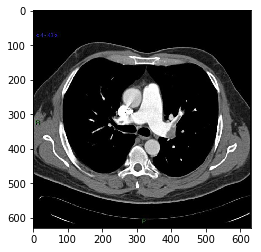

In [9]:
plt.imshow(im)

In [10]:
def im2col(img, kernel_size, s):
    streched = []
    assert img.shape[0] == img.shape[1] 

    for i in range(0, img.shape[0]-kernel_size+1, s):
        for j in range(0, img.shape[0]-kernel_size+1, s):
            flattened_im = img[i:i+kernel_size, j:j+kernel_size].reshape(-1)
            streched.append(flattened_im)
    return np.array(streched).T

def convByMatrixMul(im, w_row, kernel_size, stride):
    x_col = im2col(im, kernel_size, stride)
    w_row = w_row.reshape(w_row.shape[0], -1)
    conv = np.dot(w_row, x_col)
    w = int((im.shape[0]-kernel_size)/stride+1)
    return conv.reshape(conv.shape[0], w, w)

In [11]:
kernel_size=11
stride=4
filters_count=96

In [12]:
w_row = np.random.rand(filters_count,kernel_size,kernel_size,3)
w_rowT = torch.Tensor(w_row)
w_row.shape

(96, 11, 11, 3)

In [13]:
w_row = w_row.reshape(w_row.shape[0], -1)
w_row.shape

(96, 363)

In [14]:
convMM = convByMatrixMul(im, w_row, kernel_size, stride)
convMM.shape

(96, 155, 155)

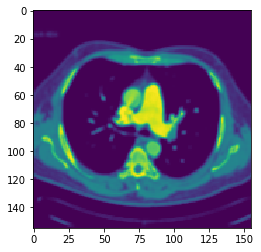

In [15]:
plt.imshow(convMM[0])

In [16]:
conv = nn.Conv2d(3, 96, kernel_size=kernel_size, stride=stride, padding=0,  bias=False)
conv.weight = torch.nn.Parameter(w_rowT.permute(0,3,1,2))
convPT = conv(torch.Tensor(im).unsqueeze(0).permute(0,3,1,2))
convPT.shape

torch.Size([1, 96, 155, 155])

In [17]:
def conv_forward(X, W, s=1):
    h_prev, w_prev = X.shape[0], X.shape[1]
    f, f = W.shape[0], W.shape[1]
    
    # no patting, stride == 1
    h = int((h_prev - f)/s + 1)
    w = int((w_prev - f)/s + 1)
    
    H = np.zeros((W.shape[0], h, w))
    for i, ww in enumerate(W):
        for j, row in enumerate(range(0, h_prev - f + 1, s)):
            for k, col in enumerate(range(0, w_prev - f + 1, s)):
                x_slice = X[row:row+f, col:col+f]
                H[i, j, k] = np.sum(x_slice*ww)
    
    return H

In [18]:
convF = conv_forward(im, w_rowT.numpy(), s=4)

In [19]:
convF.shape

(96, 155, 155)

In [20]:
np.allclose(convPT.squeeze().detach().numpy(), convF)

True

In [21]:
np.allclose(convMM, convF)

True

In [22]:
np.allclose(convPT.squeeze().detach().numpy(), convMM)

True

In [23]:
np.linalg.norm(convF-convPT.squeeze().detach().numpy())

3.1854577927780685

In [24]:
np.linalg.norm(convMM-convPT.squeeze().detach().numpy())

3.047822066936314

In [25]:
np.linalg.norm(convF-convMM)

0.9226895126556086

In [26]:
def transposeConvByConv(x, ker, k_, s_, p_, conv_variant='direct_conv'):
    assert x.shape[0] == x.shape[1]
    '''
    Transpose convolution by direct convolution
    z = s-1 (adding zeros count between rows and columns)
    p' = k-p-1
    s' = 1
    '''
    z = s_ - 1
    p = k_ - p_ - 1
    s = 1

    if z > 0:
        for i in range(x.shape[0]-1):
            j = i*(z+1)+1
            x = np.insert(x, j, np.zeros((z,x.shape[1])), axis=0)
            x = np.insert(x, j, np.zeros((z,x.shape[0])), axis=1)
            
    x = np.pad(x, p, mode='constant')      
    if conv_variant == 'direct_conv':  
        x = conv_forward(x, ker, s)

        return x
    elif conv_variant == 'conv_by_matrix':
        x = convByMatrixMul(x, ker, k_, s)
        return x

In [27]:
ker = torch.Tensor(np.random.rand(3,3))
a = torch.Tensor(np.random.rand(7,7))

In [28]:
ker

tensor([[0.9299, 0.6906, 0.6320],
        [0.7694, 0.5341, 0.7806],
        [0.6913, 0.6109, 0.2217]])

In [29]:
a

tensor([[0.1206, 0.9474, 0.4993, 0.4375, 0.4820, 0.0514, 0.0635],
        [0.3627, 0.9579, 0.0400, 0.4567, 0.3364, 0.3919, 0.2590],
        [0.2278, 0.1397, 0.2843, 0.8583, 0.6146, 0.8236, 0.7801],
        [0.4680, 0.7105, 0.8275, 0.3818, 0.3883, 0.4994, 0.0907],
        [0.4730, 0.4957, 0.8132, 0.3727, 0.4827, 0.4446, 0.2961],
        [0.2870, 0.2547, 0.9666, 0.0920, 0.1645, 0.7459, 0.6593],
        [0.5372, 0.0955, 0.6752, 0.1106, 0.4312, 0.8429, 0.0835]])

In [30]:
con_out = torch.functional.F.conv2d(a.unsqueeze(0).unsqueeze(0), weight=ker.unsqueeze(0).unsqueeze(0), )
con_out

tensor([[[[2.2097, 3.0776, 2.4655, 2.7606, 2.2952],
          [2.4370, 3.2177, 2.6135, 3.1481, 2.8625],
          [2.6835, 3.0775, 3.2861, 3.2852, 2.9405],
          [3.2806, 3.3672, 3.2410, 2.1598, 2.3188],
          [2.9868, 2.5452, 2.8698, 2.2285, 2.8142]]]])

In [31]:
torch.functional.F.conv_transpose2d(con_out, weight=ker.unsqueeze(0).unsqueeze(0), stride=1).squeeze()

tensor([[ 2.0548,  4.3880,  5.8146,  6.2147,  5.5989,  3.3297,  1.4505],
        [ 3.9664,  8.2235, 11.4584, 12.6091, 11.6526,  7.3472,  3.6006],
        [ 5.8982, 11.9702, 16.5835, 17.6960, 16.8237, 10.1074,  4.6015],
        [ 6.8001, 12.9114, 17.9922, 17.5461, 16.7599,  9.5480,  4.3952],
        [ 7.1568, 12.5397, 17.9138, 16.6450, 16.2056,  8.8011,  4.2403],
        [ 4.5660,  7.8858, 10.9240,  9.4539,  9.2368,  5.1381,  2.7107],
        [ 2.0649,  3.5844,  4.2010,  3.8581,  3.9432,  2.2133,  0.6238]])

In [32]:
transposeConvByConv(con_out.squeeze().detach().numpy(), np.expand_dims(ker.numpy(),0), 3, 2, 0, conv_variant='direct_conv').squeeze()

array([[0.48981509, 1.35004091, 2.20983982, 1.88026404, 2.67412853,
        1.50627124, 2.31634951, 1.68657255, 2.41721129, 1.40224075,
        1.58671892],
       [1.7248944 , 1.18030405, 4.10254765, 1.64386356, 4.2924614 ,
        1.31689191, 4.05182838, 1.47452438, 3.9156158 , 1.22594082,
        1.76594722],
       [1.93667388, 3.01498747, 6.39779854, 4.09133816, 7.22376823,
        3.29941988, 6.54181576, 3.82984996, 6.82840252, 3.33393002,
        4.11318874],
       [1.90228796, 1.30169022, 4.38676929, 1.71870053, 4.5158143 ,
        1.39596081, 4.46821642, 1.68151152, 4.65658665, 1.52894449,
        2.2024188 ],
       [2.13494277, 3.32256413, 6.83703375, 4.10243988, 7.49977207,
        3.81259632, 7.41976213, 4.18123531, 7.65933847, 3.77340794,
        4.69467878],
       [2.09473848, 1.43337953, 4.46702003, 1.64380968, 4.93298006,
        1.75523639, 5.09275818, 1.7547369 , 4.82301283, 1.57064867,
        2.26249313],
       [2.42308807, 3.85758376, 7.45463037, 4.18257475, 7.

In [33]:
transposeConvByConv(con_out.squeeze().detach().numpy(), np.expand_dims(ker.numpy(),0), 3, 2, 0, conv_variant='conv_by_matrix').squeeze()

array([[0.4898151, 1.3500409, 2.2098398, 1.880264 , 2.6741285, 1.5062712,
        2.3163495, 1.6865726, 2.4172113, 1.4022408, 1.5867189],
       [1.7248944, 1.180304 , 4.1025476, 1.6438636, 4.2924614, 1.3168919,
        4.0518284, 1.4745244, 3.9156158, 1.2259408, 1.7659472],
       [1.9366739, 3.0149875, 6.3977985, 4.091338 , 7.223768 , 3.2994199,
        6.5418158, 3.82985  , 6.8284025, 3.33393  , 4.1131887],
       [1.902288 , 1.3016902, 4.3867693, 1.7187005, 4.5158143, 1.3959608,
        4.4682164, 1.6815115, 4.6565866, 1.5289445, 2.2024188],
       [2.1349428, 3.3225641, 6.8370337, 4.10244  , 7.499772 , 3.8125963,
        7.419762 , 4.1812353, 7.659338 , 3.773408 , 4.694679 ],
       [2.0947385, 1.4333795, 4.46702  , 1.6438097, 4.93298  , 1.7552364,
        5.092758 , 1.7547369, 4.823013 , 1.5706487, 2.2624931],
       [2.423088 , 3.8575838, 7.454631 , 4.1825747, 7.9847126, 4.24955  ,
        7.851218 , 3.5883708, 6.92035  , 3.4474778, 4.3374577],
       [2.5607634, 1.752269 , 5.15

In [34]:
def trans_conv(x, ker, s=1):
    assert x.shape[0] == x.shape[1] and ker.shape[0] == ker.shape[1]
    k = ker.shape[0]
    h_w_out = (x.shape[0]-1)*s+ker.shape[0]
    y = np.zeros((h_w_out, h_w_out))
    for i,p in zip(range(0,y.shape[0]-k+1,s), range(x.shape[0])):
        for j,q in zip(range(0,y.shape[1]-k+1,s), range(x.shape[1])):
            y[i: i + k, j: j + k] += x[p, q] * ker
    return y

In [35]:
trans_conv(con_out.squeeze().numpy(), ker.numpy(),s=2)

array([[2.05484486, 1.52610421, 4.2583617 , 2.12547541, 4.23758543,
        1.70270896, 4.1251564 , 1.90652394, 3.87888992, 1.5851115 ,
        1.45048034],
       [1.70020807, 1.18030405, 4.09285223, 1.64386356, 4.29930031,
        1.31689191, 4.04853141, 1.47452438, 3.92081487, 1.22594082,
        1.79158807],
       [3.79382348, 3.03309453, 7.14971337, 4.10250163, 6.85040766,
        3.31121445, 7.03401572, 3.86072588, 6.84993362, 3.37912858,
        2.31773514],
       [1.87506294, 1.30169022, 4.37804723, 1.71870053, 4.52256417,
        1.39596081, 4.46224427, 1.68151152, 4.65977716, 1.52894449,
        2.23439717],
       [4.18019581, 3.34220803, 7.32237619, 4.09126878, 7.52067375,
        3.86618853, 7.88729   , 4.19215798, 7.48724711, 3.77962899,
        2.49282146],
       [2.06475925, 1.43337953, 4.46261883, 1.64380968, 4.93064952,
        1.75523639, 5.09276891, 1.7547369 , 4.82686305, 1.57064867,
        2.29534364],
       [4.90580893, 3.90515161, 7.92674631, 4.20565355, 8.

In [36]:
stride_ = 10
np.allclose(trans_conv(con_out.squeeze().numpy(), ker.numpy(),s=stride_),torch.functional.F.conv_transpose2d(con_out, weight=ker.unsqueeze(0).unsqueeze(0), stride=stride_).squeeze())

True